# Response to Reviewers
This notebook run additional analyses to address the reviewers' comments.

### imports and setups

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.feature_selection import SelectFromModel, VarianceThreshold
from sklearn.model_selection import (GridSearchCV, GroupShuffleSplit,
                                     StratifiedGroupKFold, cross_val_score)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from tqdm import tqdm

from src.sugnet.pipeline import FeatureExtractor

In [4]:
# functions
def nested_cross_validation(kinds, frequency_bands, X, y, groups, n_splits_outer=50, n_splits_inner=5):
    models = [(i, j) for i in kinds for j in frequency_bands]
    models_test_accuraies = {}
    y_preds = []

    # Choose cross-validation techniques for the inner and outer loops
    outer_cv = GroupShuffleSplit(n_splits=n_splits_outer, test_size=0.3)
    inner_cv = GroupShuffleSplit(n_splits=n_splits_inner, test_size=0.2)


    for m in tqdm(models, total=len(models)):

        kind = m[0]
        frequency_band = m[1]
        model_name = f'{kind} ({frequency_band})'
        
        print(f'>>>>>>>>>>>>>>>>>{model_name}<<<<<<<<<<<<<<<<<<')
        
        # PIPELINE
        pipe = Pipeline(steps=[
        ('extract', FeatureExtractor()),
        ('zerovar', VarianceThreshold(threshold=0.0)),
        ('scale', StandardScaler()),
        ('clf', SVC(max_iter=1000000, kernel='linear')),
        ])
        
        # grid search
        grid_params = [{
            'extract__kind': [kind],
            'extract__frequency_band': [frequency_band],
        }]
        
        test_accuraies = []
        for train, test in outer_cv.split(X, y, groups):

            # Nested CV with parameter optimization
            grid = GridSearchCV(pipe, grid_params, cv=inner_cv, scoring='accuracy', verbose=0, n_jobs=-1)
            grid.fit(X[train], y[train], groups=groups.iloc[train])
            
            # accrucy on the test set using the best estimator
            y_pred = grid.predict(X[test])
            y_preds.append(y_pred)
            test_accuraies.append((y[test] == y_pred).mean())
        
        models_test_accuraies[model_name] = test_accuraies
        return models_test_accuraies, y_preds

## Descriptive statistics

Text(0.5, 1.0, 'Hypnotizability Distribution')

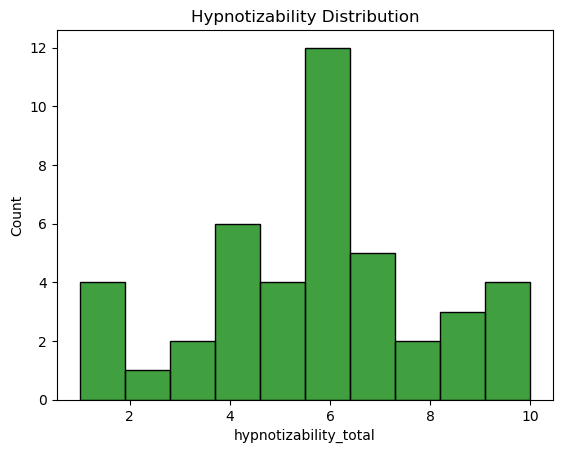

In [15]:
# open hypnotizability data
hypnotizability = pd.read_excel('data/behavioral_data/PLB_HYP_data_MASTER.xlsx').loc[9:, ['hypnotizability_total', 'bids_id']]
# hypnotizability histogram
sns.histplot(data=hypnotizability, x='hypnotizability_total', bins=10, color='green')
plt.title('Hypnotizability Distribution')

In [16]:
hypnotizability['hypnotizability_total'].describe()

count    43.00000
mean      5.72093
std       2.50072
min       1.00000
25%       4.00000
50%       6.00000
75%       7.00000
max      10.00000
Name: hypnotizability_total, dtype: float64

Text(0.5, 1.0, 'Hypnosis depth')

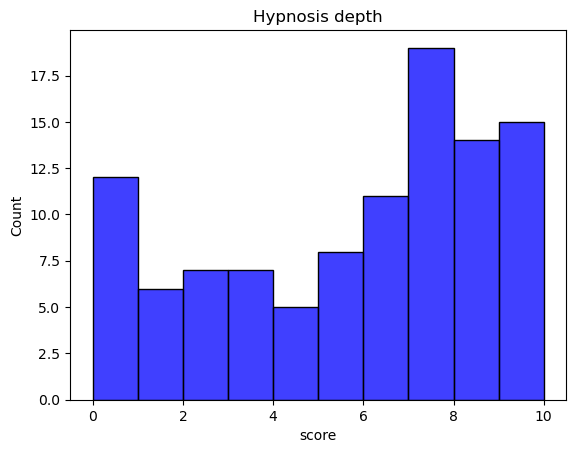

In [100]:
# open behavioral data in long format
data = pd.read_csv('data/behavioral_data/behavioral_data.csv')
data = data.query("description == 'hypnosis'")

# hypnosis depth histogram
sns.histplot(data=data, x='score', bins=10, color='blue')
plt.title('Hypnosis depth')

In [103]:
# the correlation between hypnotizability scores and hypnosis depth in all the conditions
data = pd.read_csv('data/behavioral_data/behavioral_data.csv')
data = data.query("description == 'hypnosis'").reset_index(drop=True)

hypnotizability = pd.read_excel('data/behavioral_data/PLB_HYP_data_MASTER.xlsx').loc[9:, ['bids_id', 'hypnotizability_total']]
hypnotizability = hypnotizability.loc[hypnotizability.index.repeat(2)].reset_index(drop=True)
data = pd.concat([data, hypnotizability], axis=1).dropna().reset_index(drop=True)
data[['hypnotizability_total', 'score']].corr()

,hypnotizability_total,score
hypnotizability_total,1.000000,0.580162
score,0.580162,1.000000


<Axes: xlabel='hypnotizability_total', ylabel='score'>

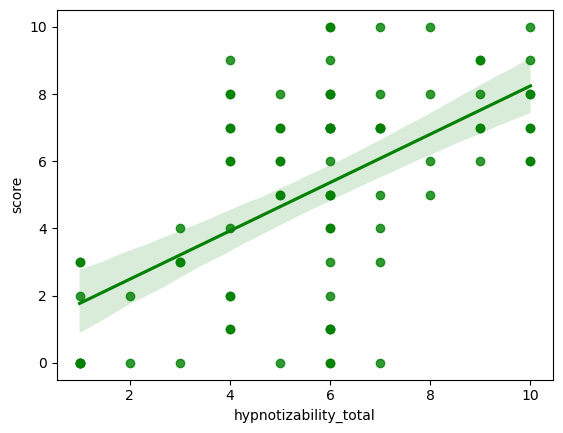

In [105]:
sns.regplot(data=data, x='hypnotizability_total', y='score', color='green')

## Using hypnotizability scores
In this section, we use the extracted features from the brain to predict hypnotizability classes. We use the same features and models as in the main paper, but instead of using hypnosis depth as the target variable, we use the hypnotizability scores.

### Load data

In [5]:
# 1. open hypnotizability data
hypnotizability = pd.read_excel('data/behavioral_data/PLB_HYP_data_MASTER.xlsx').loc[9:, ['hypnotizability_total', 'bids_id']]
hypnotizability = hypnotizability.loc[hypnotizability.index.repeat(4)].reindex()
hypnotizability['bids_id'] = hypnotizability['bids_id'].astype(int)
hypnotizability = hypnotizability.iloc[:-2].reset_index(drop=True)

# 2. open behavioral data
# 1. Data
DATA = pd.read_csv('docs/plb_hyp_data_long.csv', index_col=0)
DATA = DATA.query('condition.str.contains("experience")').reset_index(drop=True)

# 3. check if the order in the bids_id columns are the same across the two dataframes
if hypnotizability['bids_id'].equals(DATA['bids_id']):
    hypnotizability.drop(columns=['bids_id'], inplace=True)
    
    # 4. merge two dataframes
    DATA = pd.concat([DATA, hypnotizability], axis=1)
    DATA = DATA.query('description == "hypnosis"')
    DATA['bids_id'] = DATA['bids_id'].apply(lambda x: str(x).rjust(2, '0'))
    DATA.dropna(inplace=True)
else:
    print('The order of the bids_id columns are not the same across the two dataframes.')

### Analysis 1: multiclass classification + conditions:labeled as hypnosis

In [ ]:
# 5. Xy
X = DATA[['bids_id','procedure']].values
y = DATA['hypnotizability_total'].apply(lambda x: 'low' if x <= 3 else ('high' if x>=9 else 'medium')).values
groups = DATA['bids_id']

# 6. nested cross validation
kinds = ['power sensor']
frequency_bands = ['gamma']
model_name = f'{kinds[0]} ({frequency_bands[0]})'
models_test_accuraies, y_preds = nested_cross_validation(kinds, frequency_bands, X, y, groups)

In [14]:
print('>>> accuracy=', np.array(models_test_accuraies[model_name]).mean())

unique, counts = np.unique(y, return_counts=True) 
unique_groups = dict(zip(unique, counts))
print('>>> chance_level=', unique_groups['medium'] / len(y) * 100)

>>> accuracy= 0.6095692307692308
>>> chancle_level= 68.23529411764706


### Analysis 2: multiclass classification + conditions: only real hypnosis

In [21]:
# only include real hypnosis procedures
DATA2 = DATA.query('procedure == "relaxation" or procedure == "confusion"')

# 5. Xy
X = DATA2[['bids_id', 'procedure']].values
y = DATA2['hypnotizability_total'].apply(lambda x: 'low' if x <= 3 else ('high' if x>=9 else 'medium')).values
groups = DATA2['bids_id']

# 6. nested cross validation
kinds = ['correlation source']
frequency_bands = ['beta']
model_name = f'{kinds[0]} ({frequency_bands[0]})'
models_test_accuraies, y_preds = nested_cross_validation(kinds, frequency_bands, X, y, groups)

  0%|          | 0/1 [00:00<?, ?it/s]

>>>>>>>>>>>>>>>>>correlation source (beta)<<<<<<<<<<<<<<<<<<


  0%|          | 0/1 [00:12<?, ?it/s]


In [24]:
print('>>> accuracy=', np.array(models_test_accuraies[model_name]).mean())

unique, counts = np.unique(y, return_counts=True) 
unique_groups = dict(zip(unique, counts))
print('>>> chance_level=', unique_groups['medium'] / len(y) * 100)

>>> accuracy= 0.5538461538461538
>>> chance_level= 69.04761904761905
